In [47]:
!pip install tensorflow_addons

import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

#### Importing the data

In [30]:
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=e3e7fb56-0737-457a-8bbc-4ea73b62a1ab
To: /content/Images for project.zip
100% 1.42G/1.42G [00:17<00:00, 79.8MB/s]


In [31]:
!unzip -q "/content/Images for project.zip" -d /content/

replace /content/Images for project/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [32]:
!rm '/content/Images for project.zip'

#### Sorting the images into separate train-val-test folders

In [33]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

In [34]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [35]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [36]:
proportion = {
    'train': 0.75,
    'val': 0.05,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.732221
test     0.191945
val      0.075835
Name: count, dtype: float64

In [37]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

Выходные данные были обрезаны до нескольких последних строк (5000).
/content/Images for project/halo_naevus31.jpg  doesn't exist
/content/Images for project/sarcoidosis-of-the-skin-plaque-form20.jpg  doesn't exist
/content/Images for project/myiasis-furuncular_myiais16.jpg  doesn't exist
/content/Images for project/rosacea51.jpg  doesn't exist
/content/Images for project/img?imageId=7678  doesn't exist
/content/Images for project/grovers_disease_transient_acantholytic_dermatosis13.jpg  doesn't exist
/content/Images for project/solid-cysticbasalcell-carcinoma32.jpg  doesn't exist
/content/Images for project/rosacea5.jpg  doesn't exist
/content/Images for project/photodermatitis2.jpg  doesn't exist
/content/Images for project/pyogenic-granuloma111.jpg  doesn't exist
/content/Images for project/lichen_planus_follicularis24.jpg  doesn't exist
/content/Images for project/erythema_annulare_centrifugum38.jpg  doesn't exist
/content/Images for project/stephen-johnson-syndrome29.jpg  doesn't ex

#### Defining data generators

In [38]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=60,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    # shear_range=0.2,
                                    # zoom_range=0.3,
                                    brightness_range = (0.5, 1.5),
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
input_size = (128,128)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical',
        target_size = input_size)

val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = input_size)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = input_size)

Found 1732 images belonging to 114 classes.
Found 199 images belonging to 114 classes.
Found 476 images belonging to 114 classes.


#### Creating Callbacks

In [39]:
# start_time = time.time()
# top_1_acc = []
# top_3_acc = []
# top_5_acc = []
# for x_val_batch, y_val_batch in tqdm(val_generator):
#     val_predictions = model.predict(x_val_batch, verbose = 0)
#     top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
#     top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
#     top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
#     if len(top_1_acc) >= len(val_generator):
#         break
# end_time = time.time()
# duration = end_time - start_time
# print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')


In [40]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(np.argsort(y_val, axis = 1)[:,-n:] - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)


class TopNAccuracyCallback(Callback):
  def __init__(self, val_generator):
      super().__init__()
      self.val_generator = val_generator

  def on_epoch_end(self, epoch, logs=None):
      start_time = time.time()
      top_1_acc = []
      top_3_acc = []
      top_5_acc = []
      for x_val_batch, y_val_batch in self.val_generator:
        val_predictions = self.model.predict(x_val_batch, verbose = 0)
        top_1_acc.append(top_n_accuracy(y_val_batch, val_predictions, 1))
        top_3_acc.append(top_n_accuracy(y_val_batch, val_predictions, 3))
        top_5_acc.append(top_n_accuracy(y_val_batch, val_predictions, 5))
        if len(top_1_acc) >= len(self.val_generator):
          break
      end_time = time.time()
      duration = end_time - start_time
      print(f'Top-1 accuracy: {np.mean(top_1_acc):.3f}, Top-3 accuracy: {np.mean(top_3_acc):.3f}, Top-5 accuracy: {np.mean(top_5_acc):.3f}, \nTime to calculate: {duration:.2f} seconds')
top_n_accuracy_callback = TopNAccuracyCallback(val_generator)

In [41]:
class PlotMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_metrics_callback = PlotMetricsCallback()

In [42]:
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)

In [43]:
weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1_score')

#### Creating the model

In [44]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Handmade model

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),

    MaxPooling2D((4, 4)),
    Conv2D(64, (5, 5), activation='relu'),
    BatchNormalization(),

    MaxPooling2D((4, 4)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),

    # MaxPooling2D((2, 2)),
    # Conv2D(128, (3, 3), activation='relu'),
    # BatchNormalization(),

    # MaxPooling2D((2, 2)),
    # Conv2D(128, (3, 3), activation='relu'),
    # BatchNormalization(),

    Flatten(),

    # Dense(512, activation='relu'),
    # Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(114, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 batch_normalization_43 (Ba  (None, 220, 220, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 55, 55, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 51, 51, 64)        51264     
                                                                 
 batch_normalization_44 (Ba  (None, 51, 51, 64)        256       
 tchNormalization)                                               
                                                     

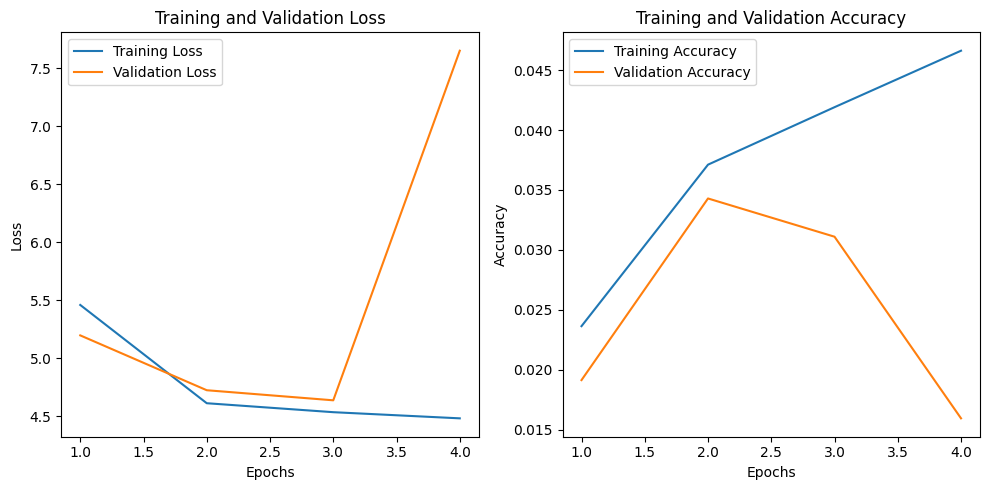

Top-1 accuracy: 0.014, Top-3 accuracy: 0.014, Top-5 accuracy: 0.017, 
Time to calculate: 9.36 seconds
379/379 [==============================] - 233s 614ms/step - loss: 4.4834 - accuracy: 0.0466 - f1_score: 0.0161 - val_loss: 7.6528 - val_accuracy: 0.0159 - val_f1_score: 0.0033
Epoch 5/10
107/379 [=======>......................] - ETA: 2:35 - loss: 4.4554 - accuracy: 0.0479 - f1_score: 0.0169

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       weighted_f1_score
                       ])

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')

### VGG

In [45]:
def scheduler(epoch, lr):
  if epoch < 5:
        return lr
  else:
        return lr * 0.9

scheduler_callback = LearningRateScheduler(scheduler)

optimizer = Adam(learning_rate=0.00001)

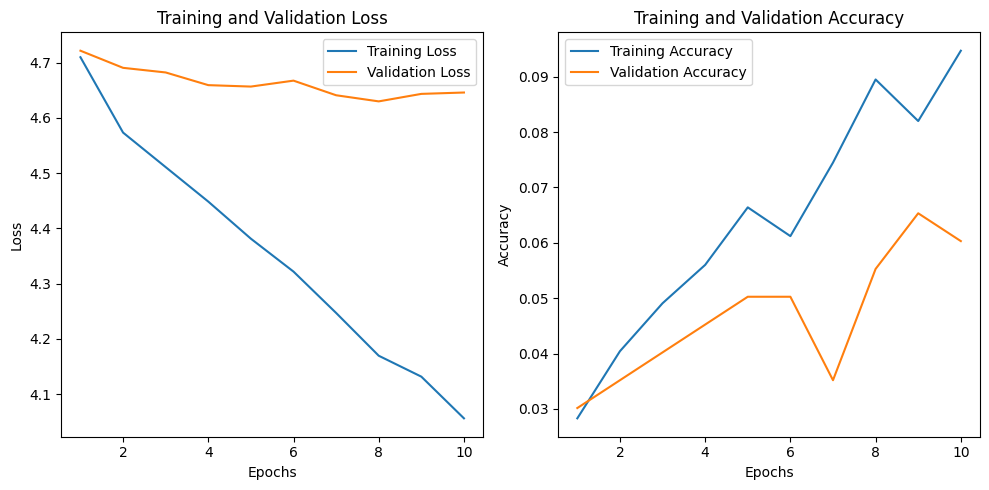

Top-1 accuracy: 0.085, Top-3 accuracy: 0.090, Top-5 accuracy: 0.094, 
Time to calculate: 1.31 seconds
55/55 [==============================] - 18s 327ms/step - loss: 4.0562 - accuracy: 0.0947 - weighted_f1_score: 0.0572 - val_loss: 4.6459 - val_accuracy: 0.0603 - val_weighted_f1_score: 0.0360 - lr: 5.9049e-06


In [46]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

flatten = layers.Flatten()(vgg.output)

dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.3)(dense)

dense = layers.Dense(256, activation='relu')(dense)
dropout = Dropout(0.3)(dense)

output = layers.Dense(114, activation='softmax')(dense)

model = models.Model(vgg.input, output)


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score])

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          steps_per_epoch=len(train_generator),
          validation_steps = len(val_generator),
          callbacks=[scheduler_callback, clear_output_callback, plot_metrics_callback, top_n_accuracy_callback],
          verbose = 'auto')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/MyDrive/Nova IMS/DL/Project/vgg19_weights_baseline_22_03.h5')

#### Further modeling

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# Flatten the output of the VGG16 network because it is a 2D array
flatten = layers.Flatten()(vgg.output)

# Add a fully connected layer with 1024 neurons
dense = layers.Dense(1024, activation='relu')(flatten)
dropout = Dropout(0.5)(dense)

# Add a fully connected layer with 256 neurons
dense = layers.Dense(256, activation='relu')(dense)
dropout = Dropout(0.5)(dense)

# We have 114 classes so we need a dense layer with 114 neurons
output = layers.Dense(114, activation='softmax')(dense)

# Create a model
model = models.Model(vgg.input, output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Train the model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator))

Epoch 1/10
379/379 [==============================] - 214s 565ms/step - loss: 4.5626 - accuracy: 0.0496 - val_loss: 4.6065 - val_accuracy: 0.0439
Epoch 2/10
379/379 [==============================] - 209s 550ms/step - loss: 4.2871 - accuracy: 0.0688 - val_loss: 4.4079 - val_accuracy: 0.0566
Epoch 3/10
379/379 [==============================] - 208s 548ms/step - loss: 4.1713 - accuracy: 0.0774 - val_loss: 4.2941 - val_accuracy: 0.0797
Epoch 4/10
379/379 [==============================] - 212s 560ms/step - loss: 4.0789 - accuracy: 0.0922 - val_loss: 4.2698 - val_accuracy: 0.0813
Epoch 5/10
379/379 [==============================] - 212s 558ms/step - loss: 4.0069 - accuracy: 0.0995 - val_loss: 4.1700 - val_accuracy: 0.0949
Epoch 6/10
379/379 [==============================] - 203s 535ms/step - loss: 3.9411 - accuracy: 0.1079 - val_loss: 4.1259 - val_accuracy: 0.0973
Epoch 7/10
379/379 [==============================] - 205s 541ms/step - loss: 3.8945 - accuracy: 0.1151 - val_loss: 4.0923 -

In [ ]:
model.save_weights('/content/vgg16-1024-256.h5')